In [1]:
import os
import pandas as pd
import numpy as np
import re
import yaml
import time
import pims
from skimage.measure import find_contours
from scipy.stats import mode

import submitit
from concurrent.futures import ProcessPoolExecutor, as_completed

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from IPython.display import clear_output

from offset_functions import run_processing, merge_falsecolor, EthogramPlotter, get_stats, CLtrajectory_plotter, increase_brightness

In [2]:
@pims.pipeline
def crop_image_center(im, width, height):
    """
    Crop the image around its center to the specified width and height.
    """
    h,w = im.shape
    im = im[h//2-height:h//2+height, w//2-width:w//2+width]
    return im

def mask_from_pos(num_frames, positions, image_size, mask_size):
    """
    Create a circular mask from coordinates for a specified image size.
    """
    # extract widths and heights
    mask_width, mask_height = mask_size[0], mask_size[1]
    image_width, image_height =  image_size[0], image_size[1]

    # circular base mask with shape of masksize
    x, y = np.ogrid[:mask_height, :mask_width]
    radius = mask_width//2
    center_x, center_y = mask_width // 2, mask_height // 2
    radius = min(mask_width, mask_height) // 2
    base_mask = ((x - center_x) ** 2 + (y - center_y) ** 2 <= radius ** 2).astype(int)

    # indices for mask, from 0 to mask_size, and recenter
    mask_rows, mask_cols = np.indices((mask_height, mask_width))
    mask_rows, mask_cols = mask_rows-mask_height//2, mask_cols-mask_width//2
    
    # Get the x and y offsets from positions
    y_offsets = positions[:, 1].reshape(num_frames, 1, 1)  # shape (num_frames, 1, 1)
    x_offsets = positions[:, 0].reshape(num_frames, 1, 1)  # shape (num_frames, 1, 1)
    # For each frame, add the offset to the mask indices.
    frame_rows = mask_rows + y_offsets  # these are the y-indices on the full image
    frame_cols = mask_cols + x_offsets    # these are the x-indices on the full image
    
    # ensure indices dont go over image size
    frame_rows[frame_rows>=image_height] = image_height-1
    frame_cols[frame_cols>=image_width] = image_width-1
    frame_rows[frame_rows<0] = 0
    frame_cols[frame_cols<0] = 0
    
    # frame indices to ensure correct indexing
    frame_indices = np.arange(num_frames).reshape(num_frames, 1, 1)
    # initiate a mask_stack of shape n_frames, image-height and -width
    mask_stack = np.zeros((num_frames, image_height, image_width), dtype=bool)
    # Now set the corresponding pixels to True.
    mask_stack[frame_indices, frame_rows, frame_cols] = base_mask

    return mask_stack

def preprocessing(fn, rec_path, cl_filepath, signal_filepath, prediction_filepath, params):
    """
    Preprocess individual movies: read files, crop images, make mask
    """
    # reading files
    cl = pd.read_csv(cl_filepath, header=None).values.reshape(-1,100,2)
    head = np.round(cl[:,0]).astype(int)
    signal = pd.read_json(signal_filepath, orient='split')
    yhat = pd.read_json(prediction_filepath, orient='split')['prediction'].values
    # reading images
    rawimages = pims.open(os.path.join(rec_path, params['pattern']))
    file_paths = rawimages._filepaths
    # if applicable only read part of recording
    if not params['nframes'] == 'all':
        rawimages = rawimages[:params['nframes']]
        file_paths = file_paths[:params['nframes']]
    # get frame indices from filenames
    frames = np.array([eval(re.split('-|_',os.path.basename(path))[-2]) for path in file_paths])

    # only keep intersection between frames
    _, intersect_vididx, intersect_signalidx = np.intersect1d(frames, signal['frame'].values, return_indices=True)
    frames = frames[intersect_vididx]
    rawimages = rawimages[intersect_vididx]
    head = head[intersect_signalidx]
    yhat = yhat[intersect_signalidx]
    
    # preprocessing
    cropped = crop_image_center(rawimages, *params['crop_size'])
    mask = mask_from_pos(head.shape[0], head, cropped[0].shape, params['mask_size']).astype(int)

    return cropped, frames, mask, yhat
    
def parallelize_processing(fn, rec_path, cl_filepath, signal_filepath, prediction_filepath, params, max_workers=None):
    """
    Parallelize processing across all movies: Preprocess, run processing (extraction of signals) then concat
    """
    cropped, frames, mask, yhat = preprocessing(fn, rec_path, cl_filepath, signal_filepath, prediction_filepath, params)
    
    futures = []
    results = []
    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(run_processing, cropped[i], frames[i], mask[i], yhat[i])\
                   for i in range(len(frames))]
        
        for future in as_completed(futures):
            try:
                result = future.result()  # This will raise an exception if the job failed
                results.append(result)
            except Exception as e:
                print(f"Job failed with exception: {e}")
                
    return results

In [3]:
outpath = ''
if not os.path.exists(outpath):
    os.makedirs(outpath)

In [4]:
imagepath = ''
inpath_macro =''
inpath_prediction = ''
config_file = ''

config = yaml.safe_load(open(config_file, "r"))

recs = sorted([dir for dir in next(os.walk(imagepath))[1] if not 'predicted'in dir])
recs = {rec: os.path.join(imagepath,rec) for rec in recs}
cl_files = {f.replace('_px_centerlines.csv',''):os.path.join(root, f) for root, dirs, files in os.walk(inpath_macro) for f in files if 'px_centerlines' in f}
signal_files = {f.replace('_signals.json',''):os.path.join(root, f) for root, dirs, files in os.walk(inpath_macro) for f in files if 'signals.json' in f}
prediction_files = {f.replace('_signalsneg_prediction.json',''):os.path.join(root, f) for root, dirs, files in os.walk(inpath_prediction) for f in files if 'prediction.json' in f}

pop_id = [f for f in sorted(prediction_files) if not any(str(n) in f for n in [73, 74, 78, 81, 82, 88, 90, 91, 92])]
[prediction_files.pop(p) for p in pop_id];

In [5]:
sorted(prediction_files)

['ER_Predation_73',
 'ER_Predation_74',
 'ER_Predation_78',
 'ER_Predation_81',
 'ER_Predation_88',
 'ER_Predation_90',
 'ER_Predation_91',
 'ER_Predation_92']

In [6]:
params = dict(pattern = '*-minor.tiff',
              crop_size = (50,50), # (100,100) #important set to crop like when centerline was created!!!
              mask_size = (30,30),
              nframes = 'all'
              )

In [7]:
# parallel analysis
executor = submitit.SlurmExecutor(folder='logs-preycontact')

# Setting the parameters for the slurm job
executor.update_parameters(
    partition="CPU,GPU",
    time="01:00:00",  
    mem="350G",
    cpus_per_task=48,
    comment="mda-job",
    job_name="mda-job",
    array_parallelism=100,
)

class sham_job():
    def __init__(self,df):
        self.df = df
        self.state = 'loaded from file'
    def results(self):
        return [self.df]
        
jobs = []
process_files = prediction_files.copy()
for fn in sorted(process_files):
    processed_file = os.path.join(outpath,fn+'_GFPsignal.csv')
    if os.path.exists(processed_file):
        print(fn, 'loaded from file')
        df = pd.read_csv(os.path.join(outpath,fn+'_GFPsignal.csv'))
        jobs.append([fn,sham_job(df)])
        process_files.pop(fn)

with executor.batch():
    for fn in sorted(process_files):
        print(fn, 'submitted to slurm')
        job = executor.submit(parallelize_processing, 
                              fn,
                              recs[fn],
                              cl_files[fn], 
                              signal_files[fn], 
                              prediction_files[fn], 
                              params,)
        jobs.append([fn, job])

ER_Predation_73 loaded from file
ER_Predation_74 loaded from file
ER_Predation_78 loaded from file
ER_Predation_81 loaded from file
ER_Predation_88 loaded from file
ER_Predation_90 loaded from file
ER_Predation_91 loaded from file
ER_Predation_92 loaded from file


/gpfs/soma_fs/home/boeger/usr/miniconda3/envs/mda/lib/python3.10/site-packages/submitit/core/core.py:718: RuntimeWarning: No submission happened during "with executor.batch()" context.
  warnings.warn(


In [8]:
# wait for jobs to finish
while any([j[1].state == 'RUNNING' or j[1].state == 'PENDING' for j in jobs]):
    time.sleep(5)
    clear_output(wait=True)
    states = [j[1].state == 'RUNNING' or j[1].state == 'PENDING' for j in jobs]
    print(len(states)-sum(states),'/', len(states),'\n', *[str(j)+'\n' for j in jobs])
dict_df = {j[0]: pd.DataFrame(j[1].results()[0], columns=['frames','max','mean','5 percentile','95 percentile','mask size','prediction']).sort_values(by=['frames']).reset_index(drop=True) for j in jobs}

In [9]:
# save files
for fn in dict_df:
    processed_file = os.path.join(outpath,fn+'_GFPsignal.csv')
    if not os.path.exists(processed_file):
        print(fn)
        dict_df[fn].to_csv(processed_file)

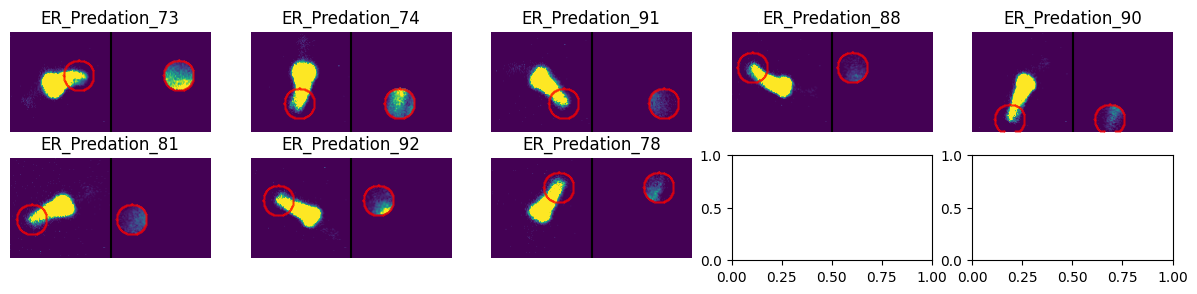

In [10]:
# make sure mask is correct
fr=0
fig, axs = plt.subplots((len(dict_df)//5)+1,5, figsize=(15,(len(dict_df)//5)*3))
axs = axs.flatten()
for i in range(len(prediction_files)):
    fn = list(prediction_files.keys())[i]
    cropped, frames, mask, yhat = preprocessing(fn,
                                                recs[fn],
                                                cl_files[fn], 
                                                signal_files[fn], 
                                                prediction_files[fn], 
                                                dict(params, nframes=1))
    main = pims.open(os.path.join(recs[fn], '*main.tiff'))
    main = main[:1]
    main = crop_image_center(main, *params['crop_size'])
    double_img = np.hstack([main[fr],cropped[fr]*mask[fr]])
    axs[i].imshow(double_img, vmin=0, vmax=20)
    axs[i].scatter(find_contours(mask[fr])[0].T[1],find_contours(mask[fr])[0].T[0], s=.1,c='r')
    axs[i].scatter(find_contours(mask[fr])[0].T[1]+main[fr].shape[0],find_contours(mask[fr])[0].T[0], s=.1,c='r')
    axs[i].set_title(fn)
    axs[i].axvline(main[fr].shape[0],c='k')
    axs[i].axis('off')
plt.show()

In [40]:
# Create dataframe aligned at bite onsets, with an edge of 15 s
edge = 15
fps = 30
aligned_biting_df = pd.DataFrame([], dtype='object')
all_df = pd.DataFrame([])
for fn in dict_df:
    print(fn, end='')
    # read df for fn
    df = dict_df[fn].reset_index(drop=True)

    # exclude if signal not observable
    if np.median(df['mean'])<=.1:
        print(' not included')
        continue
    print('')
    
    # calculate preysignal and smooth
    df['ratio'] = ((df['95 percentile']+1)-(df['5 percentile']+1)) / (df['5 percentile']+1)
    df['ratio_smooth'] = df['ratio'].rolling(fps, min_periods=1).mean()
    df['mean_smooth'] = df['mean'].rolling(fps, min_periods=1).mean()

    # create multiframe df
    df_new = df.copy()
    df_new.columns = pd.MultiIndex.from_product([[fn],df_new.columns])

    # store unaligned df 
    all_df = pd.concat([all_df, df_new],axis=1)

    # get bite events and onsets from prediction
    bite_idx = np.where(df_new[fn]['prediction']==1)[0]
    if len(bite_idx) == 0:
        continue
    onsets = bite_idx[[0]+list(np.where(bite_idx[:-1]+1 < bite_idx[1:])[0]+1)]
    # ignore bite events if previous bite event starting within edge
    #onsets_woprev = [0]+list(np.where(np.diff(onsets)>fps*edge)[0]+1)
    #onsets = onsets[onsets_woprev]
    
    # create aligned df
    for on in onsets:
        if on-fps*edge < 0:
            split = df_new[fn][0:on+fps*edge]
            baseline = split['ratio'].loc[:on-5*fps].mean()
            split['ratio_percent'] =  (split['ratio']-baseline)/baseline
            split['ratio_percent_smooth'] =  split['ratio_percent'].rolling(fps, min_periods=1).mean()
            split.index = np.arange(30*edge-on,len(split)+(fps*edge-on))
        else:
            split = df_new[fn][on-fps*edge:on+fps*edge]
            baseline = split['ratio'].loc[:on-5*fps].mean()
            split['ratio_percent'] =  (split['ratio']-baseline)/baseline
            split['ratio_percent_smooth'] =  split['ratio_percent'].rolling(fps, min_periods=1).mean()
            split =split.reset_index(drop=True)
        split.columns = pd.MultiIndex.from_product([['aligned biting'],[fn], [on], split.columns])
        aligned_biting_df = pd.concat([aligned_biting_df, split],axis=1)
    
aligned_biting_df = aligned_biting_df.sort_index()
aligned_biting_df_copy = aligned_biting_df.copy()

ER_Predation_73
ER_Predation_74
ER_Predation_78
ER_Predation_81
ER_Predation_88
ER_Predation_90
ER_Predation_91
ER_Predation_92


In [41]:
# group all df by prediction, assign each worm a color
grouped = all_df.groupby(level=0, axis=1).apply(lambda x: x.droplevel(0,axis=1).groupby('prediction'))
all_df_mean = pd.concat({grouped.index[i]:gr.mean() for i,gr in enumerate(grouped)})
all_df_mean['color'] = all_df_mean.index.get_level_values(0)
all_df_mean['color'] = all_df_mean['color'].replace(all_df_mean['color'].unique(), np.arange(0,1,1/len(all_df_mean['color'].unique())))

/tmp/ipykernel_168189/1316785821.py:2: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  grouped = all_df.groupby(level=0, axis=1).apply(lambda x: x.droplevel(0,axis=1).groupby('prediction'))
/tmp/ipykernel_168189/1316785821.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  all_df_mean['color'] = all_df_mean['color'].replace(all_df_mean['color'].unique(), np.arange(0,1,1/len(all_df_mean['color'].unique())))


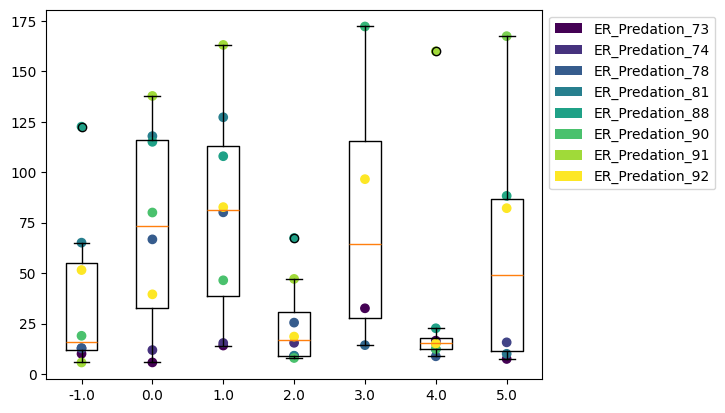

In [42]:
# create boxplot for each behavior showing mean GFP signal across worms
for name, group in all_df_mean.reset_index('prediction').groupby('prediction'):
    group['color'] = np.arange(0,1,1/group.shape[0])
    group['name'] = group.index
    plt.boxplot(group['ratio_smooth'], positions=[name], widths=[.45])
    plt.scatter(np.repeat(name,group.shape[0]), group['ratio_smooth'], c=group['color'])
    
plt.legend(handles=[Patch(facecolor=c) for c in plt.get_cmap(lut=len(all_df_mean['color'].unique())).colors],
            labels=list(all_df_mean.index.get_level_values(0).unique()),
          loc='upper left', bbox_to_anchor=(1,1))
plt.savefig(os.path.join(outpath,  'GFPoverbeheavior_boxplot.pdf'),  bbox_inches = "tight")

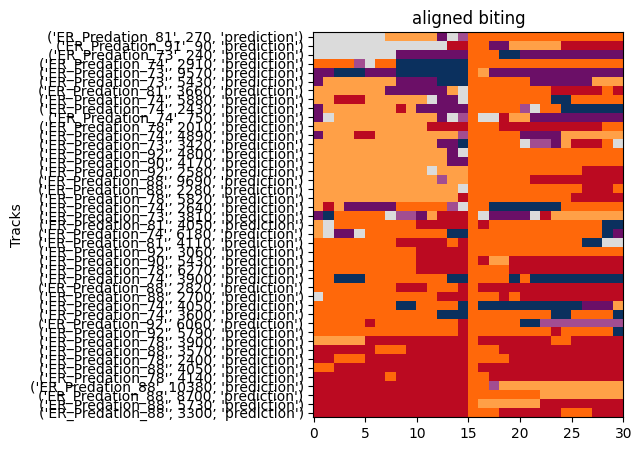

In [43]:
# create stacked ethogram
idx = pd.IndexSlice
cluster_color = config['cluster_color']
cluster_label = config['cluster_labels']
# sort aligned df by mode and count of behavior prior biting
aligned_sorted = aligned_biting_df.loc[:fps*edge,idx[:,:,:,'prediction']].apply(lambda s: mode(s)).T.sort_values([0,1], ascending=[True,False])
aligned_sorted_idx = aligned_sorted.index
# make figure
etho = EthogramPlotter(aligned_biting_df.loc[:,idx[aligned_sorted_idx]], cluster_color, cluster_label, fps, xtick_spread=5, multi_level=0)
stacked_etho = etho.multi_stack(multi_level=0)
stacked_etho.savefig(os.path.join(outpath,  'EthogramStacked_Biting.svg'),  bbox_inches = "tight")

In [44]:
# create sorted index to get the same slices as in stacked ethogram
aligned_sorted_idx_upper = aligned_sorted_idx.droplevel(-1)
index_upper_df = aligned_sorted_idx_upper.to_frame()
index_last_df = aligned_biting_df.columns.get_level_values(-1).to_frame(name=index_upper_df.shape[1]).reset_index(drop=True)
index_upper_df = pd.DataFrame(np.repeat(index_upper_df.values, len(np.unique(index_last_df)), axis=0), columns=index_upper_df.columns).reset_index(drop=True)
index_all_df = pd.concat([index_upper_df,index_last_df], axis=1)

# create index slices with non-predatory behavior before bite onset
nonpred_index = (aligned_sorted[aligned_sorted[0]>=2]).droplevel(-1).index.to_frame()
nonpred_index = pd.DataFrame(np.repeat(nonpred_index.values, len(np.unique(index_last_df)), axis=0), columns=nonpred_index.columns).reset_index(drop=True)
nonpred_index = pd.concat([nonpred_index,pd.DataFrame(np.tile(np.unique(index_last_df),(aligned_sorted[aligned_sorted[0]>=2]).shape[0]))], axis=1)

# create index slices with only bite behavior before bite onset
pred_index = (aligned_sorted[np.bitwise_or(aligned_sorted[0]==1, aligned_sorted[0]==0)]).droplevel(-1).index.to_frame()
pred_index = pd.DataFrame(np.repeat(pred_index.values, len(np.unique(index_last_df)), axis=0), columns=pred_index.columns).reset_index(drop=True)
pred_index = pd.concat([pred_index,pd.DataFrame(np.tile(np.unique(index_last_df),(aligned_sorted[np.bitwise_or(aligned_sorted[0]==1,aligned_sorted[0]==0)]).shape[0]))], axis=1)

In [45]:
# create df from index to access slices shown in stacked etho
aligned_sorted_idx_all = pd.MultiIndex.from_frame(index_all_df)
aligned_biting_df = aligned_biting_df.loc[:,idx[aligned_sorted_idx_all]]
# create df with prebiting only "non-predatory" behaviors
aligned_sorted_nonpred_idx = pd.MultiIndex.from_frame(nonpred_index)
aligned_biting_nonpred_df = aligned_biting_df.loc[:,idx[aligned_sorted_nonpred_idx]]
# create df with prebiting only "non-predatory" behaviors
aligned_sorted_biting_idx = pd.MultiIndex.from_frame(pred_index)
aligned_biting_biting_df = aligned_biting_df.loc[:,idx[aligned_sorted_biting_idx]]

/tmp/ipykernel_168189/4260468041.py:3: MatplotlibDeprecationWarning: Passing label as a length 4 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(aligned_biting_nonpred_df[ser], label=ser)


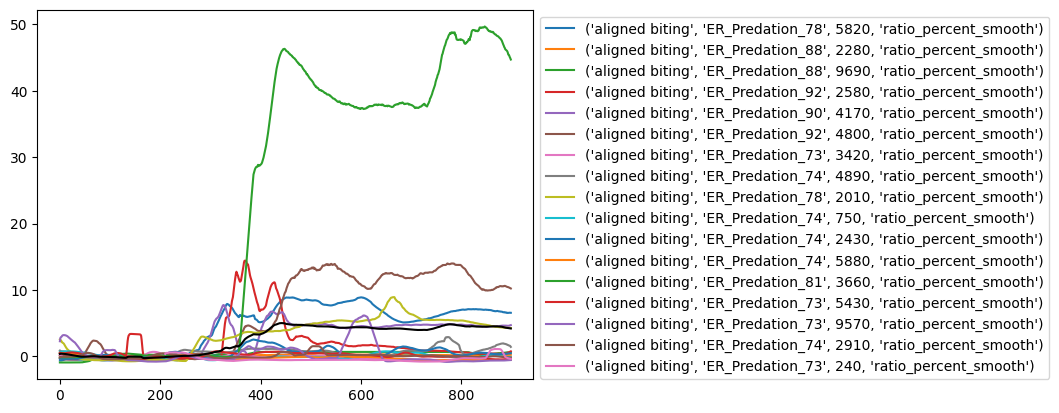

In [46]:
# plot individual traces
for ser in aligned_biting_nonpred_df.loc[:,idx[:,:,:,'ratio_percent_smooth']]:
    plt.plot(aligned_biting_nonpred_df[ser], label=ser)
plt.plot(aligned_biting_nonpred_df.loc[:,idx[:,:,:,'ratio_percent_smooth']].mean(axis=1), c='k')
plt.legend(loc='upper left', bbox_to_anchor=(1,1))

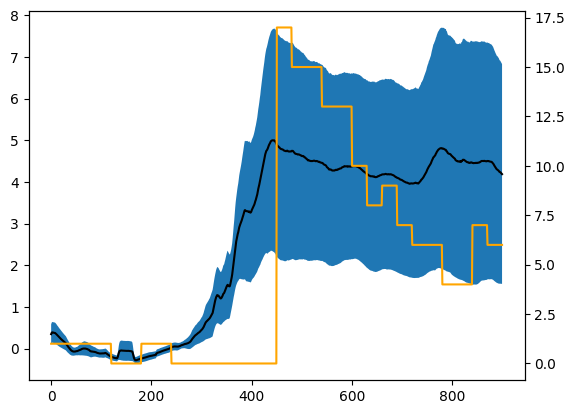

In [47]:
# plot mean trace
aligned_mean = aligned_biting_nonpred_df.loc[:,idx[:,:,:,'ratio_percent_smooth']].mean(axis=1)
aligned_sem = aligned_biting_nonpred_df.loc[:,idx[:,:,:,'ratio_percent_smooth']].sem(axis=1)
aligned_std = aligned_biting_nonpred_df.loc[:,idx[:,:,:,'ratio_percent_smooth']].std(axis=1)

fig, ax = plt.subplots(1)
ax2 = ax.twinx()
ax.plot(aligned_mean, c='k')
#ax.fill_between(aligned_mean.index, aligned_mean-aligned_std, aligned_mean+aligned_std)
ax.fill_between(aligned_mean.index, aligned_mean-aligned_sem, aligned_mean+aligned_sem)
ax2.plot((aligned_biting_nonpred_df.loc[:,idx[:,:,:,'prediction']]==1).sum(axis=1), c='orange')
plt.savefig(os.path.join(outpath,  'GFPaligned_biting_woprevbiting.pdf'),  bbox_inches = "tight")

In [48]:
t, p, cohens_d, N_animals, N_traces = get_stats(aligned_biting_nonpred_df.loc[:,idx[:,:,:,'ratio_percent_smooth']], range(15*30,30*30), range(10*30), level_animals=1)
stats_df = pd.DataFrame([['non predatory', t, p, cohens_d, N_animals, N_traces]], columns=['prediction filter','t statistic', 'p value', 'cohens_d', 'N animals', 'N traces'])
stats_df

,prediction filter,t statistic,p value,cohens_d,N animals,N traces
0,non predatory,1.757554,0.048968,-45.397065,7,17


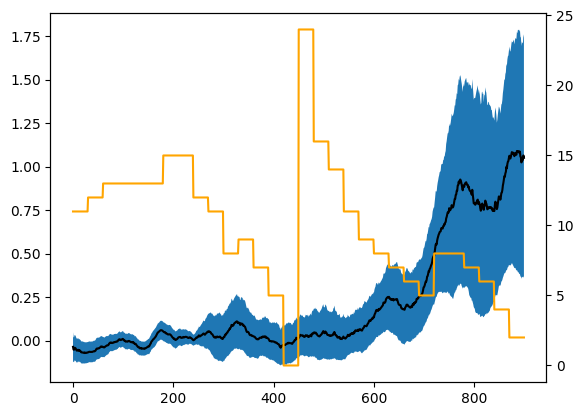

In [49]:
aligned_mean = aligned_biting_biting_df.loc[:,idx[:,:,:,'ratio_percent_smooth']].mean(axis=1)
aligned_sem = aligned_biting_biting_df.loc[:,idx[:,:,:,'ratio_percent_smooth']].sem(axis=1)
aligned_std = aligned_biting_biting_df.loc[:,idx[:,:,:,'ratio_percent_smooth']].std(axis=1)

fig, ax = plt.subplots(1)
ax2 = ax.twinx()
ax.plot(aligned_mean, c='k')
#ax.fill_between(aligned_mean.index, aligned_mean-aligned_std, aligned_mean+aligned_std)
ax.fill_between(aligned_mean.index, aligned_mean-aligned_sem, aligned_mean+aligned_sem)
ax2.plot((aligned_biting_biting_df.loc[:,idx[:,:,:,'prediction']]==1).sum(axis=1), c='orange')
plt.savefig(os.path.join(outpath,  'GFPaligned_biting_prevbiting.pdf'),  bbox_inches = "tight")

In [50]:
t, p, cohens_d, N_animals, N_traces = get_stats(aligned_biting_biting_df.loc[:,idx[:,:,:,'ratio_percent_smooth']], range(10*30,17*30), range(7*30), level_animals=1)
stats_df = pd.concat([stats_df,
                     pd.DataFrame([['predatory', t, p, cohens_d, N_animals, N_traces]], columns=['prediction filter','t statistic', 'p value', 'cohens_d', 'N animals', 'N traces'])])
stats_df

,prediction filter,t statistic,p value,cohens_d,N animals,N traces
0,non predatory,1.757554,0.048968,-45.397065,7,17
0,predatory,0.292729,0.386177,-0.254369,7,24


#### example 

In [22]:
fn = 'ER_Predation_92'
# get paths for fn
rec_path = recs[fn]
cl_filepath = cl_files[fn].replace('px', 'um')
signal_filepath = signal_files[fn]
prediction_filepath = prediction_files[fn]

# load data for example
cl = pd.read_csv(cl_filepath, header=None).values.reshape(-1,100,2)
head = np.round(cl[:,0]).astype(int)

signal = pd.read_json(signal_filepath, orient='split')

metrics = pd.read_json(prediction_filepath, orient='split')
metrics['ratio_smooth'] = all_df[fn]['ratio_smooth']
yhat = metrics['prediction'].values

# load images
minorimages = pims.open(os.path.join(rec_path, '*-minor.tiff'))
mainimages = pims.open(os.path.join(rec_path, '*-main.tiff'))
# crop images
minorimages = crop_image_center(minorimages, 100,100)
mainimages = crop_image_center(mainimages, 100,100)

In [23]:
# define range and example sec
fr_rng = range(45*30,150*30)
example_sec = [63, 87, 136]
example_c = ['c','m','y']

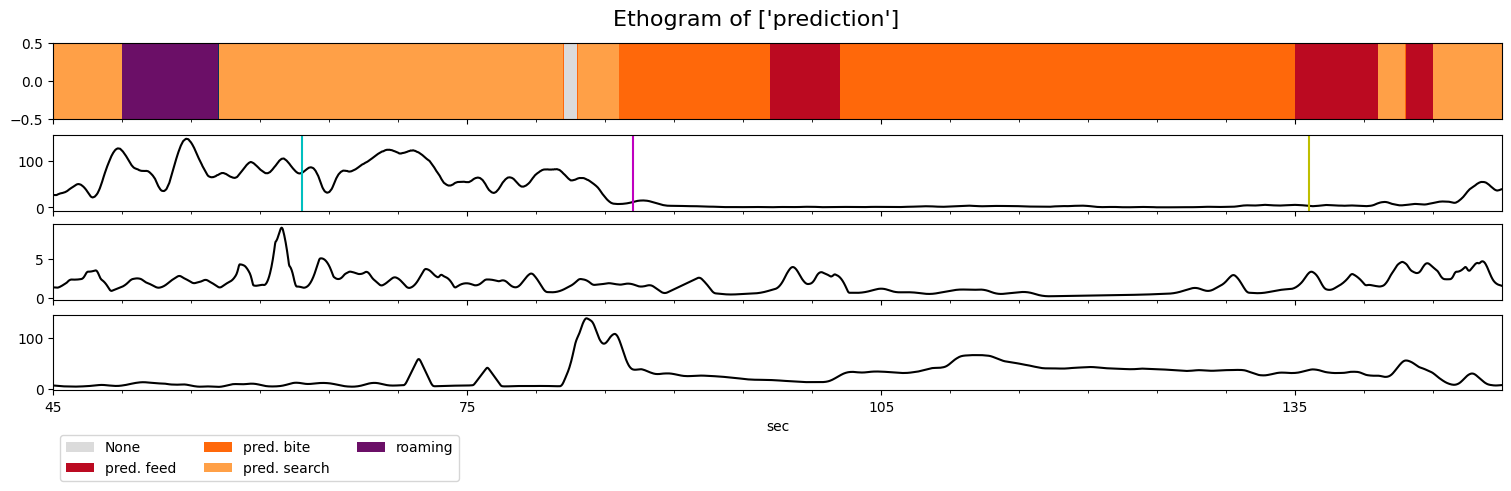

In [24]:
# make single ethogram for example
etho = EthogramPlotter(metrics.iloc[fr_rng], cluster_color, cluster_label, fps, xtick_spread = 30, multi_level=0)
single_etho = etho.single(['prediction'], metrics=[metrics['velocity_dt60'].iloc[fr_rng],metrics['rate'].iloc[fr_rng], metrics['ratio_smooth'].iloc[fr_rng]], adaptive_figsize=(15,1.2))
for fr,c in zip(example_sec, example_c):
    single_etho.axes[1].axvline(fr*30-fr_rng[0],c=c)
single_etho.savefig(os.path.join(outpath,  f'EthogramExample_{fn}_{fr_rng[0]}-{fr_rng[-1]}.svg'))

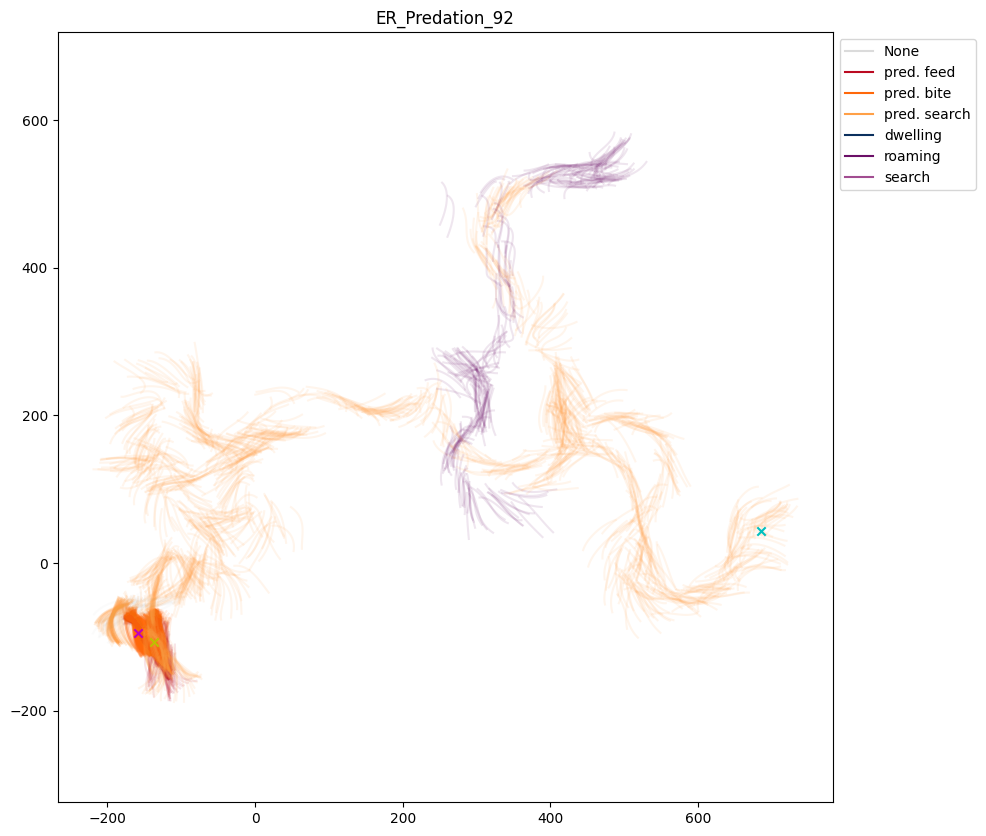

In [25]:
clplot = CLtrajectory_plotter(cl[fr_rng], signal[['x','y']].values[fr_rng], yhat[fr_rng], cluster_color, cluster_label, fn)
for fr,c in zip(example_sec, example_c):
    CLine = cl[fr*30]
    XY = signal[['x','y']].values[fr*30]
    adjustCL = (CLine-np.nanmean(CLine))+(XY-np.nanmean(signal[['x','y']].values[fr_rng], axis=0))
    clplot.axes[0].scatter(*np.mean(adjustCL, axis=0), marker='x',c=c, zorder=5)
plt.savefig(os.path.join(outpath,  f'CLtrackExample_{fn}_{fr_rng[0]}-{fr_rng[-1]}.pdf'),  bbox_inches = "tight", dpi=300)

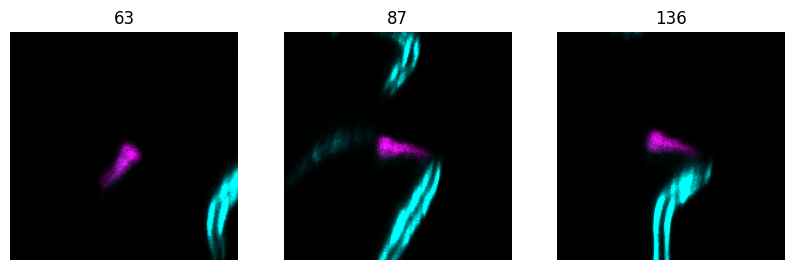

In [26]:
fig, axs = plt.subplots(1,3, figsize=(10,3))
for ax,fr in zip(axs, example_sec):
    ax.imshow(merge_falsecolor([mainimages[fr*30],minorimages[fr*30]], [[255,0,255],[0,255,255]], [2.5,1.5], avoid_oversat=False))
    ax.set_title(fr)
    ax.axis('off')
plt.savefig(os.path.join(outpath,  f'StillExample_{fn}_{fr_rng[0]}-{fr_rng[-1]}.pdf'),  bbox_inches = "tight", dpi=300)